In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import Tensor
from pathlib import Path
from typing import Dict
from albumentations.pytorch import ToTensorV2
import albumentations as A
import pandas as pd
import os
from torch.nn import functional as F
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch import nn
import torch.optim as optim
import wandb
from tqdm.notebook import tqdm
import math
import torch.nn.init as init
from torch.utils.data import Subset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import cv2

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



from fashion_classification import FashionClassification

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

In [21]:
IMAGE_SIZE = 500
BATCH_SIZE = 16
# Number of worker threads for loading the data
NUM_WORKERS = 12  # Adjust this depending on your system's capabilities
VAL_TEST_NUMBER_OF_WORKERS = 4
# mean=(0.4467, 0.4114, 0.3829)
# std=(0.2970, 0.2885, 0.2922)

mean = (0.3195, 0.2940, 0.2738)
std = (0.3226, 0.3070, 0.3018)

INPUT_CHANNELS = 3
NUMBER_OF_EPOCHS = 100000 # we will stop manually
LOG_INTERVAL = 12000 # logging every n th batch
TRAIN_SAMPLE_SIZE = 2000
VALIDATION_SAMPLE_SIZE = -1

LR = 0.001


#MobileNetV3 cfgs
cfgs = [
    # k, t, c, SE, HS, s 
    [3,   1,  16, 0, 0, 1],
    [3,   4,  24, 0, 0, 2],
    [3,   3,  24, 0, 0, 1],
    [5,   3,  40, 1, 0, 2],
    [5,   3,  40, 1, 0, 1],
    [5,   3,  40, 1, 0, 1],
    [3,   6,  80, 0, 1, 2],
    [3, 2.5,  80, 0, 1, 1],
    [3, 2.3,  80, 0, 1, 1],
    [3, 2.3,  80, 0, 1, 1],
    [3,   6, 112, 1, 1, 1],
    [3,   6, 112, 1, 1, 1],
    [5,   6, 160, 1, 1, 2],
    [5,   6, 160, 1, 1, 1],
    [5,   6, 160, 1, 1, 1]
]

In [4]:
images_folder_path = '../6/images/'
images_file_names = os.listdir(images_folder_path)
classes_mappings = pd.read_csv('../6/annotations/matched_classes.csv').sort_values(by='DisplayName')
classes_mappings['index_column'] = range(len(classes_mappings))
label_names = classes_mappings['LabelName'].to_numpy()

label_to_index_mapping = {label: index for index, label in enumerate(label_names)}
index_to_label_mapping = {index: label for index, label in enumerate(label_names)}

print(label_to_index_mapping)
print(len(index_to_label_mapping))

{'/m/01940j': 0, '/m/03grzl': 1, '/m/015h_t': 2, '/m/0176mf': 3, '/m/03p3bw': 4, '/m/01b638': 5, '/m/01bl7v': 6, '/m/01gmv2': 7, '/m/0584n8': 8, '/m/09j2d': 9, '/m/01xygc': 10, '/m/025rp__': 11, '/m/0nl46': 12, '/m/01d40f': 13, '/m/01r546': 14, '/m/0463sg': 15, '/m/02fq_6': 16, '/m/07qxg_': 17, '/m/09j5n': 18, '/m/05r655': 19, '/m/0jyfg': 20, '/m/0174n1': 21, '/m/02_n6y': 22, '/m/080hkjn': 23, '/m/02dl1y': 24, '/m/0zvk5': 25, '/m/06k2mb': 26, '/m/0dzf4': 27, '/m/02p0tk3': 28, '/m/039xj_': 29, '/m/014sv8': 30, '/m/0dzct': 31, '/m/031n1': 32, '/m/03q69': 33, '/m/0k65p': 34, '/m/04hgtk': 35, '/m/035r7c': 36, '/m/0283dt1': 37, '/m/0k0pj': 38, '/m/032b3c': 39, '/m/0fly7': 40, '/m/0hf58v5': 41, '/m/04yx4': 42, '/m/01cmb2': 43, '/m/01llwg': 44, '/m/01g317': 45, '/m/02p3w7d': 46, '/m/03nfch': 47, '/m/02h19r': 48, '/m/01n4qj': 49, '/m/01bfm9': 50, '/m/02wv6h6': 51, '/m/016m2d': 52, '/m/01nq26': 53, '/m/02jfl0': 54, '/m/0h8mhzd': 55, '/m/01xyhv': 56, '/m/01s55n': 57, '/m/02wbtzl': 58, '/m/017ftj

In [5]:
# transforms = A.Compose([
#     A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
#     # A.HorizontalFlip(p=0.5),             # Random horizontal flipping
#     # A.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE), # Random cropping
#     A.Normalize(mean=mean, std=std),
#     ToTensorV2(),
# ])

In [6]:
transforms = A.Compose([
    A.LongestMaxSize(max_size=IMAGE_SIZE),  # Resize the longest side of the image to IMAGE_SIZE
    A.PadIfNeeded(
        min_height=IMAGE_SIZE,
        min_width=IMAGE_SIZE,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),  # Pad to make the image square
    # A.HorizontalFlip(p=0.5),             # Random horizontal flipping
    # A.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE), # Random cropping
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

In [7]:
def split_dataset(file_names, test_size=0.1, val_size=0.1):
    # Split into train and test
    train_files, test_files = train_test_split(file_names, test_size=test_size, random_state=42)
    
    # Further split test set into validation and test
    val_files, test_files = train_test_split(test_files, test_size=val_size, random_state=42)

    return train_files, val_files, test_files

train_files, val_files, test_files = split_dataset(images_file_names)

In [8]:
# dataset = FashionClassification(images_folder_path, images_file_names, '../6/annotations/concatenated_classes.csv', label_to_index_mapping, index_to_label_mapping, transforms)
# Instantiate the datasets
train_dataset = FashionClassification(images_folder_path, train_files, '../6/annotations/concatenated_classes.csv', label_to_index_mapping, index_to_label_mapping, transforms)
val_dataset = FashionClassification(images_folder_path, val_files, '../6/annotations/concatenated_classes.csv', label_to_index_mapping, index_to_label_mapping, transforms)
test_dataset = FashionClassification(images_folder_path, test_files, '../6/annotations/concatenated_classes.csv', label_to_index_mapping, index_to_label_mapping, transforms)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VAL_TEST_NUMBER_OF_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VAL_TEST_NUMBER_OF_WORKERS, pin_memory=True)

# # Calculate the sizes of the subsets
# train_subset_size = math.floor((1/10000) * len(train_dataset))
# val_subset_size = math.floor((1/20) * len(val_dataset))
# test_subset_size = math.floor((1/20) * len(test_dataset))

# # Create subsets
# train_subset = Subset(train_dataset, range(50))
# val_subset = Subset(val_dataset, range(50))
# test_subset = Subset(test_dataset, range(10))

# # Define data loaders using the subsets
# train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
# val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VAL_TEST_NUMBER_OF_WORKERS, pin_memory=True)
# test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VAL_TEST_NUMBER_OF_WORKERS, pin_memory=True)



In [10]:
# print(test_dataset[0][1].shape)
# print(test_dataset[0][0].shape)
# print(test_dataset[0][1])

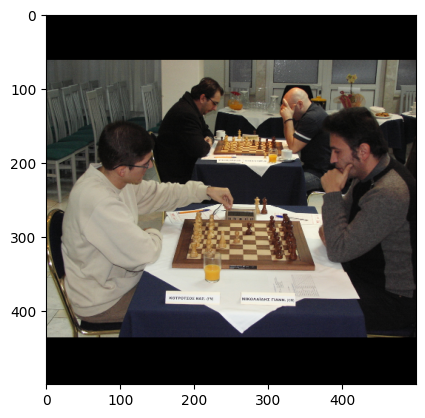

In [136]:
def denormalize(tensor, mean, std):
    denormalized = tensor.clone()
    for t, m, s in zip(denormalized, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    return denormalized

plt.imshow(denormalize(test_dataset[6][0],mean, std ).numpy().transpose(1, 2, 0))
# plt.imshow(test_dataset[6][0].numpy().transpose(1, 2, 0))

In [12]:
# df = pd.read_csv('MobileNetV3Base.csv')
# df = df.dropna()
# df

In [13]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class SqueezeExcitation(nn.Module):
    def __init__(self, number_of_input_channels, squeeze_factor=4):
        super(SqueezeExcitation, self).__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1)) # input (32, 9, 7, 7) -> output (32, 9, 1, 1)

        number_of_channels_squeezed = _make_divisible(number_of_input_channels // squeeze_factor, 8)
        self.excitation = nn.Sequential(
            nn.Linear(number_of_input_channels, number_of_channels_squeezed), # (32, 9, 1, 1) -> (32, 3, 1, 1)
            nn.ReLU(inplace=True),
            # nn.ReLU(),
            nn.Linear(number_of_channels_squeezed, number_of_input_channels), # (32, 3, 1, 1) -> (32, 9, 1, 1)
            nn.Hardsigmoid(),
        )

    def forward(self, input:Tensor):
        batch_size, number_of_channels, _, _ = input.size()
        output = self.squeeze(input).view(batch_size, number_of_channels) # gives batch_size,number_of_channels, 1, 1 as we want 1,1 as output. So we remove the 1,1
        output = self.excitation(output).view(batch_size, number_of_channels, 1, 1)
        return input * output

class Bneck(nn.Module):
    def __init__(self, number_of_input_channels, number_of_expansion_channels, number_of_output_channels, kernel_size, stride, use_squeeze_excite, use_hard_swish):
        super(Bneck, self).__init__()
        assert stride in [1, 2]

        self.is_dimension_constant = stride == 1 and number_of_input_channels == number_of_output_channels
        is_not_expanding = number_of_input_channels == number_of_expansion_channels

        padding = (kernel_size - 1) // 2

        # more useful in deeper layers probably
        if is_not_expanding:
            self.bneck = nn.Sequential(
                # Depthwise Convs
                nn.Conv2d(number_of_input_channels, number_of_expansion_channels, kernel_size, stride, padding, groups=number_of_expansion_channels, bias=False),
                nn.BatchNorm2d(number_of_expansion_channels),
                nn.Hardswish(inplace=True) if use_hard_swish else nn.ReLU(inplace=True),
                # nn.Hardswish() if use_hard_swish else nn.ReLU(),

                # Squeeze and Excite
                SqueezeExcitation(number_of_expansion_channels) if use_squeeze_excite else nn.Identity(),

                # Pointwise Convs Linear
                nn.Conv2d(number_of_expansion_channels, number_of_output_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(number_of_output_channels)
            )
        else:
            self.bneck = nn.Sequential(
                # Pointwise Convs
                nn.Conv2d(number_of_input_channels, number_of_expansion_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(number_of_expansion_channels),
                nn.Hardswish(inplace=True) if use_hard_swish else nn.ReLU(inplace=True),
                # nn.Hardswish() if use_hard_swish else nn.ReLU(),

                # Deptwise Convs
                nn.Conv2d(number_of_expansion_channels, number_of_expansion_channels, kernel_size, stride, padding, groups=number_of_expansion_channels, bias=False),
                nn.BatchNorm2d(number_of_expansion_channels),
                
                # Squeeze and Excite
                SqueezeExcitation(number_of_expansion_channels) if use_squeeze_excite else nn.Identity(),

                # Pointwise Convs Linear
                nn.Conv2d(number_of_expansion_channels, number_of_output_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(number_of_output_channels),
            )

    def forward(self, input):
        if self.is_dimension_constant:
            return input + self.bneck(input)
        else:
            return self.bneck(input)

def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.Hardswish(inplace=True),
        # nn.Hardswish()
    )

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.Hardswish(inplace=True)
        # nn.Hardswish()
    )

class MobileNetV3(nn.Module):
    def __init__(self, configurations, number_of_classes=68, width_multiplier=1.5):
        super(MobileNetV3, self).__init__()
        self.configurations = configurations

        # first layer
        number_of_input_channels = _make_divisible(self.configurations[0][2], 8)
        layers = [conv_3x3_bn(3, number_of_input_channels, 2)]

        # Mid layers
        for kernel_size, layer_expand_width, number_of_output_channels, use_squeeze_excite, use_hard_swish, stride in self.configurations:
            number_of_output_channels_with_width = _make_divisible(number_of_output_channels * width_multiplier, 8)
            number_of_expansion_channels = _make_divisible(number_of_input_channels * layer_expand_width, 8)
            layers.append(Bneck(number_of_input_channels, number_of_expansion_channels, number_of_output_channels_with_width, kernel_size, stride, use_squeeze_excite, use_hard_swish))
            number_of_input_channels = number_of_output_channels_with_width
        self.mid_layers = nn.Sequential(*layers)

        # Last layers
        self.point_wise_convolution = conv_1x1_bn(number_of_input_channels, number_of_expansion_channels)
        self.average_pooling = nn.AdaptiveAvgPool2d((1,1))

        # classifier layers
        number_of_output_channels_with_width = _make_divisible(1280 * width_multiplier, 8) if width_multiplier > 1.0 else 1280
        self.classifier = nn.Sequential(
            nn.Linear(number_of_expansion_channels, number_of_output_channels_with_width),
            nn.Hardswish(inplace=True),
            # nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(number_of_output_channels_with_width, number_of_classes),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def forward(self, input):
        input = self.mid_layers(input)
        input = self.point_wise_convolution(input)
        input = self.average_pooling(input)
        input = input.view(input.size(0), -1)
        input = self.classifier(input)
        return input

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    
dummy_input = torch.randn(1, 3, 224, 224)
dummy_input = dummy_input.to("cuda")
# df_without_classifier = df.iloc[:-1]
model = MobileNetV3(cfgs, len(index_to_label_mapping)).to('cuda')

dummy_output = model(dummy_input)
print(dummy_output.shape)
del model
del dummy_input
del dummy_output

torch.Size([1, 68])


In [14]:
# Dictionary to hold the activations
activations = {}
model = MobileNetV3(cfgs, len(index_to_label_mapping)).to('cuda')
# model._initialize_weights()

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for i, layer in enumerate(model.mid_layers):
    layer.register_forward_hook(get_activation(f'Layer {i} ({layer.__class__.__name__})'))


dummy_input = torch.randn(1, 3, 224, 224).to("cuda")

dummy_output = model(dummy_input)




Layer 0 (Sequential): mean 0.17, std 0.55, saturated: 9.01%
Layer 1 (Bneck): mean -0.00, std 1.00, saturated: 30.41%
Layer 2 (Bneck): mean 0.00, std 1.00, saturated: 32.20%
Layer 3 (Bneck): mean -0.00, std 1.42, saturated: 48.72%
Layer 4 (Bneck): mean 0.00, std 1.00, saturated: 33.12%
Layer 5 (Bneck): mean 0.00, std 1.41, saturated: 48.99%
Layer 6 (Bneck): mean 0.00, std 1.73, saturated: 57.20%
Layer 7 (Bneck): mean 0.00, std 1.00, saturated: 32.83%
Layer 8 (Bneck): mean 0.00, std 1.43, saturated: 49.14%
Layer 9 (Bneck): mean -0.00, std 1.75, saturated: 57.60%
Layer 10 (Bneck): mean -0.00, std 2.01, saturated: 62.22%
Layer 11 (Bneck): mean 0.00, std 1.00, saturated: 32.57%
Layer 12 (Bneck): mean -0.00, std 1.41, saturated: 47.47%
Layer 13 (Bneck): mean 0.00, std 1.00, saturated: 33.02%
Layer 14 (Bneck): mean -0.00, std 1.42, saturated: 48.83%
Layer 15 (Bneck): mean -0.00, std 1.74, saturated: 56.90%


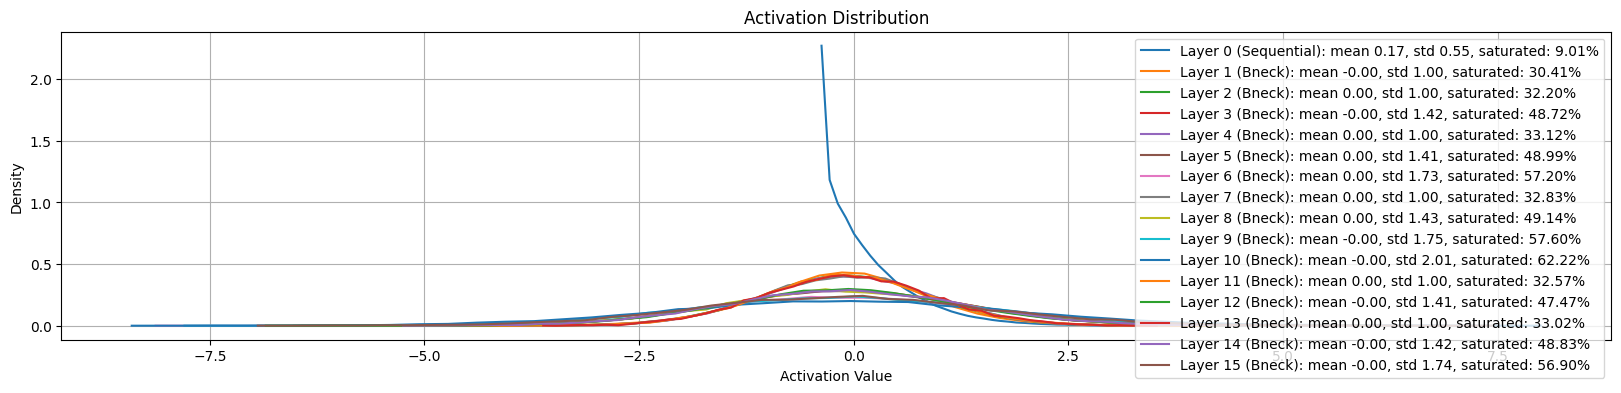

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
count = 0
for name, activation in activations.items():
    activation = activation.cpu().numpy()  # Convert to NumPy array for processing
    flattened_activation = activation.flatten()  # Flatten the tensor to 1D for histogram
    
    # Calculate statistics
    mean = np.mean(flattened_activation)
    std = np.std(flattened_activation)
    saturated = (np.abs(flattened_activation) > 0.97).mean() * 100  # Assuming saturation means abs value > 0.97
    
    # Print statistics
    print(f'{name}: mean {mean:.2f}, std {std:.2f}, saturated: {saturated:.2f}%')
    
    # Histogram
    hy, hx = np.histogram(flattened_activation, bins=50, density=True)
    plt.plot(hx[:-1], hy, label=f'{name}: mean {mean:.2f}, std {std:.2f}, saturated: {saturated:.2f}%')
    count+=1
    
    
plt.legend(loc='upper right')
plt.title('Activation Distribution')
plt.xlabel('Activation Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()
del model
del dummy_output
del dummy_input


In [16]:
wandb.init(project="Encoder2")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: binaryaz. Use `wandb login --relogin` to force relogin


In [17]:
def get_sample_loaders(train_dataset, val_dataset, train_subset_size, val_subset_size, batch_size, num_workers):
    if val_subset_size == -1:
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=VAL_TEST_NUMBER_OF_WORKERS, pin_memory=True)
    else:
        val_indices = np.random.choice(len(val_dataset), val_subset_size, replace=False)
        val_sampler = SubsetRandomSampler(val_indices)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers, pin_memory=True)

    if train_subset_size == -1:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    else:
        train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
        train_sampler = SubsetRandomSampler(train_indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [18]:
def validate(model, loader, criterion, threshold=0, device='cuda'):
    model.eval()
    total_loss = 0.0
    progress_bar = tqdm(loader, total=len(loader), desc="Validating", leave=False)
    with torch.no_grad():
        for index, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Apply threshold if it's set
            if threshold != 0:
                outputs = (outputs > threshold).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            progress_bar.set_postfix({"loss": total_loss / (index + 1)})
    avg_val_loss = total_loss / len(loader)

    model.train()
    return avg_val_loss

In [19]:
def get_training_performance(model, validation_loader, training_loader, criterion, current_running_epoch, total_number_of_epochs):
    # Calculate training loss over all batches up to the current batch
    training_loss = validate(model, training_loader, criterion)

    # Perform validation
    validation_loss = validate(model, validation_loader, criterion)

    # Log training and validation metrics
    wandb.log({
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }, step=(current_running_epoch * len(training_loader)))  # Unique step value for each log

    print(f"Batch {current_running_epoch + 1}/{len(training_loader)}, Epoch {current_running_epoch + 1}/{total_number_of_epochs}")
    print(f"Training Loss: {training_loss}")
    print(f"Validation Loss: {validation_loss}")

    return validation_loss, training_loss


def save_best(model, current_val_loss, best_val_loss, epoch, optimizer):
    # Check if this is the best model so far based on validation accuracy
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        # Save checkpoint
        best_model = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }
        torch.save(best_model, 'best_model.pth')

In [20]:
# from torchvision.models import resnet50, ResNet50_Weights

# Define your MobileNetV3 model and move it to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = resnet50(num_classes=len(index_to_label_mapping)).to(device)
model = MobileNetV3(cfgs, len(index_to_label_mapping)).to(device)
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Suitable for multi-label classification
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

best_val_loss = float('inf') # Keep track of the best validation accuracy

# Training loop
for current_running_epoch in range(NUMBER_OF_EPOCHS):
    model.train()
    training_running_loss = 0.0
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {current_running_epoch+1}/{NUMBER_OF_EPOCHS}")

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_running_loss += loss.item()
        pbar.set_postfix({"Loss": training_running_loss / (batch_idx + 1)})

        # # Perform validation and log metrics every log_interval batches
        # if (batch_idx + 1) % LOG_INTERVAL == 0:
        #     val_loss, training_loss = get_training_performance(model, val_loader, training_running_loss, criterion, current_running_epoch, NUMBER_OF_EPOCHS, batch_idx )
        #     save_best(model, val_loss, best_val_loss, current_running_epoch, batch_idx, optimizer)


    sample_train_loader, sample_val_loader = get_sample_loaders(train_dataset, val_dataset, TRAIN_SAMPLE_SIZE, VALIDATION_SAMPLE_SIZE, BATCH_SIZE, VAL_TEST_NUMBER_OF_WORKERS)
    val_loss, training_loss = get_training_performance(model, sample_val_loader, sample_train_loader, criterion, current_running_epoch, NUMBER_OF_EPOCHS)
    save_best(model, val_loss, best_val_loss, current_running_epoch, optimizer)
        
    ########################################## OVERFIT ##########################################
    # training_loss = validate(model, train_loader, criterion, device=device)
    # # validation_loss = validate(model, val_loader, criterion, device)

    # wandb.log({
    #     "Training Loss": training_loss,
    #     # "Validation Loss": validation_loss
    # }, step=(current_running_epoch * len(train_loader)))  # Unique step value for each log
     ########################################## OVERFIT ##########################################


    # Save checkpoint
    checkpoint = {
        'epoch': current_running_epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint, f'checkpoint_epoch_{current_running_epoch+1}.pth')

# Save the final model
torch.save(model.state_dict(), 'mobilenetv3_model.pth')


validate(model, test_loader, criterion, device)

9537444


Epoch 1/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 1/125, Epoch 1/100000
Training Loss: 0.12542068034410478
Validation Loss: 0.1253742688382991


Epoch 2/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 2/125, Epoch 2/100000
Training Loss: 0.12242220163345337
Validation Loss: 0.1237057431357708


Epoch 3/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 3/125, Epoch 3/100000
Training Loss: 0.12224008172750472
Validation Loss: 0.12067893583586173


Epoch 4/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 4/125, Epoch 4/100000
Training Loss: 0.11232190656661988
Validation Loss: 0.11052054831258722


Epoch 5/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 5/125, Epoch 5/100000
Training Loss: 0.10626359009742736
Validation Loss: 0.10783513529725604


Epoch 6/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 6/125, Epoch 6/100000
Training Loss: 0.09998749217391015
Validation Loss: 0.10404954440348739


Epoch 7/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 7/125, Epoch 7/100000
Training Loss: 0.0983307880461216
Validation Loss: 0.10092103689420279


Epoch 8/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 8/125, Epoch 8/100000
Training Loss: 0.09900584656000137
Validation Loss: 0.10454398498159169


Epoch 9/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 9/125, Epoch 9/100000
Training Loss: 0.0969821605682373
Validation Loss: 0.10915133119769763


Epoch 10/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 10/125, Epoch 10/100000
Training Loss: 0.09482879996299744
Validation Loss: 0.09679079001128536


Epoch 11/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 11/125, Epoch 11/100000
Training Loss: 0.09659517741203308
Validation Loss: 0.1025095828817775


Epoch 12/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 12/125, Epoch 12/100000
Training Loss: 0.09758836415410042
Validation Loss: 0.09791315719985418


Epoch 13/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 13/125, Epoch 13/100000
Training Loss: 0.09103743219375611
Validation Loss: 0.09528491656768583


Epoch 14/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 14/125, Epoch 14/100000
Training Loss: 0.09239085537195206
Validation Loss: 0.11725273729013697


Epoch 15/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 15/125, Epoch 15/100000
Training Loss: 0.13553504943847655
Validation Loss: 0.11611911874746036


Epoch 16/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/5214 [00:00<?, ?it/s]

Batch 16/125, Epoch 16/100000
Training Loss: 0.09226201483607292
Validation Loss: 0.1179471511342343


Epoch 17/100000:   0%|          | 0/52133 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [113]:
from sklearn.metrics import accuracy_score, f1_score

def validate2(model, loader, criterion, threshold=0.5, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute loss with probabilities, not thresholded values
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Apply threshold to get binary predictions
            predictions = (outputs > threshold).float()

            # Append labels and predictions to list without transferring to CPU
            all_labels.append(labels)
            all_predictions.append(predictions)

    # Calculate average loss
    avg_val_loss = total_loss / len(loader)

    # Concatenate all labels and predictions on GPU and then transfer to CPU for sklearn metrics
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
    all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()

    # Calculate additional metrics on CPU
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    model.train()
    return avg_val_loss, accuracy, f1



In [117]:
def load_best(model, device):
    checkpoint = torch.load('checkpoint_epoch_12.pth')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_val_loss = checkpoint['best_val_loss']
    model.to(device)
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3(cfgs, len(index_to_label_mapping)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.BCELoss()  # Suitable for multi-label classification
load_best(model, device)
loss, acc, f1 = validate2(model, test_loader, criterion, threshold=0.2, device=device)
print(loss, 1-acc, f1)

0.09678069741689953 0.9235084690905168 0.6796166478049825


In [118]:
# 0.9235084690905168 

(tensor([[[-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904],
         [-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904],
         [-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904],
         ...,
         [-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904],
         [-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904],
         [-0.9904, -0.9904, -0.9904,  ..., -0.9904, -0.9904, -0.9904]],

        [[-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577],
         [-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577],
         [-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577],
         ...,
         [-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577],
         [-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577],
         [-0.9577, -0.9577, -0.9577,  ..., -0.9577, -0.9577, -0.9577]],

        [[-0.9072, -0.9072, -0.9072,  ..., -0.9072, -0.9072, -0.9072],
         [-0.9072, -0.9072, -0.9072,  ..., -

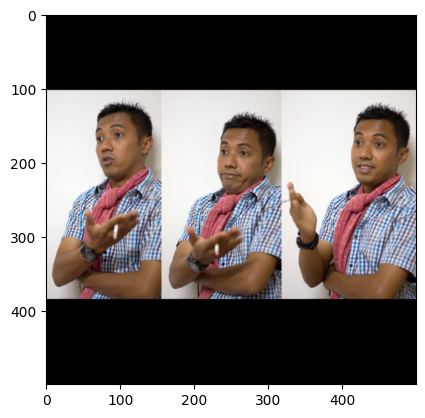

In [236]:
example_index =344
input = test_dataset[example_index]
print(test_dataset[example_index])
output = model(input[0].to(device).unsqueeze(0))
plt.imshow(denormalize(test_dataset[example_index][0],mean, std ).numpy().transpose(1, 2, 0))

In [237]:
_output = (output>0.2).float()
_true_output = test_dataset[example_index][1].to(device)
comparison = _output == _true_output

In [238]:
comparison

tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True]],
       device='cuda:0')

In [239]:
# Count the number of True values (same values)
num_same = comparison.sum().item()

# Calculate the total number of elements in the tensor
total_elements = comparison.nelement()  # or comparison.numel()

# Calculate the percentage of same values
percentage_same = (num_same / total_elements) * 100

print(f'Percentage of same values: {percentage_same}%')


Percentage of same values: 95.58823529411765%


In [240]:
_output.shape


torch.Size([1, 68])

In [241]:
final_prediction_test = _output.squeeze(0)
final_true_test = _output.squeeze(0)
indices_prediction = torch.where(final_prediction_test == 1.0)[0]
indices_true = torch.where(final_true_test == 1.0)[0]

In [242]:
labels_in_image_predicted = [index_to_label_mapping[idx.item()] for idx in indices_prediction]
labels_in_image_true = [index_to_label_mapping[idx.item()] for idx in indices_true]


In [243]:
classes_mappings

,LabelName,DisplayName,index_column
0,/m/01940j,Backpack,0
1,/m/03grzl,Baseball glove,1
2,/m/015h_t,Beard,2
3,/m/0176mf,Belt,3
4,/m/03p3bw,Bicycle helmet,4
...,...,...,...
63,/m/01rkbr,Tie,63
64,/m/07mhn,Trousers,64
65,/m/0hnnb,Umbrella,65
66,/m/0gjkl,Watch,66


In [244]:
matching_rows_predicted = classes_mappings[classes_mappings['LabelName'].isin(labels_in_image_predicted)]
matching_rows_true = classes_mappings[classes_mappings['LabelName'].isin(labels_in_image_true)]
display(matching_rows_predicted)
display(matching_rows_true)

,LabelName,DisplayName,index_column
9,/m/09j2d,Clothing,9
18,/m/09j5n,Footwear,18
19,/m/05r655,Girl,19
31,/m/0dzct,Human face,31
42,/m/04yx4,Man,42
45,/m/01g317,Person,45
56,/m/01xyhv,Suit,56
67,/m/03bt1vf,Woman,67


,LabelName,DisplayName,index_column
9,/m/09j2d,Clothing,9
18,/m/09j5n,Footwear,18
19,/m/05r655,Girl,19
31,/m/0dzct,Human face,31
42,/m/04yx4,Man,42
45,/m/01g317,Person,45
56,/m/01xyhv,Suit,56
67,/m/03bt1vf,Woman,67
